# Categorical VAE using VI with Mixture of Discrete Normalizing Flows

A version using the one-file implementation of factorized flows from *mdnf/flows_factorized_mixture.py*

Design of the VAE follows the implementation from https://github.com/ericjang/gumbel-softmax

## Imports and Helper Functions

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfpd

import copy
import time
import pandas as pd

In [2]:
tf.__version__, tfp.__version__

('2.2.0', '0.9.0')

In [3]:
import sys
sys.path.append('../mdnf')

In [4]:
import aux

In [5]:
import flows_factorized_mixture

## Configuration

In [6]:
# can be run as a script with args in format KEY=VAL,KEY=[STRVAL],...
args = aux.parse_script_args() 

In [7]:
SEED = args.get("SEED", 0)
OUT = args.get("OUT", "VAEFlows.csv")

B = args.get("B", 40) # how many flows in mixture
N = args.get("N", 10) # how many latent variables
K = args.get("K", 2) # how many categories each

# Temperature hyperparameter
BASE_TEMP = args.get("BASE_TEMP", 100.0)
ANNEAL_RATE = args.get("ANNEAL_RATE", 0.00003)
MIN_TEMP = args.get("MIN_TEMP", 0.001)

OPTIMIZER = args.get("OPTIMIZER", "ADAM")
LR = args.get("LR", 0.001)
BATCH_SIZE = args.get("BATCH_SIZE", 256) # how many samples in minibatch
NUM_ITERS = args.get("NUM_ITERS", 100) # how many epochs

NSAMPLES = args.get("NSAMPLES", 1) # how many samples per data point in each step (=how many ELBOs evaluations)

In [8]:
CFG = ["VAE_FLOWS", SEED, OUT, B, N, K, BATCH_SIZE, NUM_ITERS, 
       BASE_TEMP, None, OPTIMIZER, LR, ANNEAL_RATE, MIN_TEMP]
print("CFG=%s" % CFG)

CFG=['VAE_FLOWS', 0, 'VAEFlows.csv', 40, 10, 2, 256, 100, 100.0, None, 'ADAM', 0.001, 3e-05, 0.001]


## MDNF

In [9]:
temperature = tf.Variable(BASE_TEMP, name="temperature") #!

In [10]:
mixture = flows_factorized_mixture.FactorizedDiscreteFlowsMixture(N, K, B, temperature=1.0)
print("mixture = %s" % mixture)

mixture = <flows_factorized_mixture.FactorizedDiscreteFlowsMixture object at 0x7fe1d8c45a60>


## Inference

In [11]:
OPTIMIZERS = {"RMS": tf.keras.optimizers.RMSprop,
              "ADAM": tf.keras.optimizers.Adam}
if OPTIMIZER not in OPTIMIZERS: raise ValueError("Unknown optimizer!")
optimizer_class = OPTIMIZERS[OPTIMIZER]
optimizer = optimizer_class(learning_rate=LR)

print("optimizer=%s lr=%s" % (optimizer, LR))

optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fe1c8bc3700> lr=0.001


## VAE Model

In [12]:
class CategoricalVAE(tf.Module):

    def __init__(self, mixture, N, K, name=None):
        """
        
            Args:
                N  number of variables
                K  number of categories for each variable
                B  number of components in a mixture of flows
        """
        super(CategoricalVAE, self).__init__(name=name)
        
        self.mixture = mixture

        self.N = N # number of categorical distributions
        self.K = K # number of classes
        
        
        self.calc_logits_z = tf.keras.Sequential([ # encoder
                                             tf.keras.layers.Flatten(name="encoder0"),
                                             tf.keras.layers.Dense(512, activation="relu", 
                                                                   input_shape=(None, 784), name="encoder1"),
                                             tf.keras.layers.Dense(256, activation="relu", name="encoder2"),
                                             tf.keras.layers.Dense(K*N, activation=None, name="encoder3"),
                                             tf.keras.layers.Reshape( [N,K] , name="encoder4")
                                            ], name="encoder")

        self.calc_logits_x = tf.keras.Sequential( # decoder
                                            [tf.keras.layers.Flatten(name="decoder0"),
                                             tf.keras.layers.Dense(256, activation="relu", name="decoder1"),
                                             tf.keras.layers.Dense(512, activation="relu", name="decoder2"),
                                             tf.keras.layers.Dense(784, activation=None, name="decoder3"),
                                            ], name="decoder")         
        
        #B = len(mixture.flows)
        B = mixture.logits.shape[1]
        self.calc_logits_flows = tf.keras.Sequential([ 
                                             tf.keras.layers.Flatten(name="flows0"),
                                             tf.keras.layers.Dense(K*N*B, activation="relu", 
                                                                   input_shape=(None, 784), name="flows1"),
                                             tf.keras.layers.Dense(K*N*B, activation=None, name="flows2"),
                                             tf.keras.layers.Reshape( [B,N,K] , name="flows3")
                                            ], name="logits_flows")        
        
    def __call__(self, x):       
        # variational posterior q(z|x), i.e. the encoder 
        # unnormalized logits for N separate K-categorical distributions (shape=(batch_size,N,K))                
        logits_z = self.calc_logits_z(x)        

        logits_flows = self.calc_logits_flows(logits_z)
        self.mixture.logits = tf.transpose(logits_flows, [0,2,1,3])
        batch_size = logits_flows.shape[0]
        samples, mask = self.mixture.sample_extm(batch_size)      

        # generative model p(x|z)
        logits_x = self.calc_logits_x(samples)    
        p_x = tfpd.Bernoulli(logits=logits_x)
        
        return p_x, samples
    
    def log_prob(self, samples): # for entropy/KL evaluation
        samples_inv = self.mixture.reverse(samples)
        return self.mixture.log_prob_ext(samples_inv)[0,:] 
    
    @property
    def temperature(self):
        return self.mixture.temperature
    
    @temperature.setter
    def temperature(self, value):
        self.mixture.temperature = value
    

## Training

In [13]:
# get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
frmt = lambda images: tf.cast(tf.reshape(images,(-1, 784)), tf.float32)/255.0
x_train, x_test = frmt(x_train), frmt(x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [14]:
def loss_MC(x, p_x, vae, samples): 
    """
        Args:
            samples  Samples from latent representation
    """
    batch_size, N, K = samples.shape
    
    H_q = -vae.log_prob(samples) 
    Eq_logp = tf.reduce_sum(samples*np.log(1./K), [-1,-2])
    KL = -H_q -Eq_logp

    lik = tf.reduce_sum(p_x.log_prob(x), -1) # sums over 784 pixels
    
    #print("lik=%.4f KL=%.4f prior=%.4f entropy_q=%.4f" % 
    #      ( tf.reduce_mean(lik), tf.reduce_mean(KL), tf.reduce_mean(prior_samples), tf.reduce_mean(entropy_q)))
    return tf.reduce_mean(lik), tf.reduce_mean(KL), tf.reduce_mean(Eq_logp), tf.reduce_mean(H_q)

In [15]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
vae = CategoricalVAE(mixture, N, K)
loss = loss_MC
results = []
best_loss, best_vae = float("inf"), None
i = 0

In [17]:
def true_loss(x, p_x, vae, nsamples=1000, *args):
    """ Estimate negative ELBO from samples. 
        
        Used only as a sanity check.
        Computationally extremely expensive.
    """
    batch_size,N,K = x.shape[0], vae.N, vae.K
    
    # sampling:
    ss = []
    self = vae
    logits_z = self.calc_logits_z(x)                
    for _ in range(nsamples):
        logits_flows = self.calc_logits_flows(logits_z)
        self.mixture.logits = tf.transpose(logits_flows, [0,2,1,3])
        batch_size = logits_flows.shape[0]
        samples, mask = self.mixture.sample_extm(batch_size) 
        ss.append(samples)
       
    py = tf.reduce_mean(tf.stack(ss), 0)
    H_q = -tf.reduce_sum(py*np.log(py+1e-31), [-1,-2]) # sum over categories and then over independent variables

    Eq_logp = np.sum(np.mean(np.ones((batch_size,N,K))*np.log(1/K), -1), -1)

    KL = -Eq_logp -H_q
    Eq_logp = float(tf.reduce_mean(Eq_logp))
    H_q = float(tf.reduce_mean(H_q))
    KL = float(tf.reduce_mean(KL))
    lik = tf.reduce_sum(p_x.log_prob(x), -1)
    lik = float(tf.reduce_mean(lik))
    return -(lik-KL), lik, KL, Eq_logp, H_q

In [18]:
def _eval_elbo_from_samples_(e):
    # since it's extremely expensive 
    # we perform this sanity check only twice
    if not (e<0 or e==NUM_ITERS-1 or e==0): 
        tl, true_lik, true_KL = float("inf"), float("-inf"), float("inf")
        true_Eq_logp, true_H_q = float("nan"), float("nan")        
        return tl, true_lik, true_KL, true_Eq_logp, true_H_q
    
    nbatches = len(x_train)/BATCH_SIZE
    how_many_batches = max( 100 / ((N*K)/10), 20 )
    #how_many_batches = 3
    p_keep = how_many_batches / nbatches

    print("[%.1fs] epoch=%i/iteration=%i: evaluating ELBO from samples on around %d batches..." % 
          (time.time()-start, e, i, int(p_keep*nbatches)))
    
    true_losses = []
    true_liks, true_KLs, true_Eq_logps, true_H_qs = [], [], [], []  
    #train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE, drop_remainder=True)
    for batch_no, (batch_x, labels) in enumerate(train_ds):
        p_x, samples = vae(batch_x)
        if (np.random.uniform()<p_keep):
            tl, true_lik, true_KL, true_Eq_logp, true_H_q = true_loss(batch_x, p_x, vae)
            true_losses.append(tl)
            true_liks.append(true_lik); true_KLs.append(true_KL); 
            true_Eq_logps.append(true_Eq_logp); true_H_qs.append(true_H_q);
            print("[%.2f]  batch_ix=%d. > ELBO=%.2f lik=%.2f KL=%.2f Eqlogp=%.2f Hq=%.2f" % (
                  time.time()-start, batch_no, -tl, true_lik, true_KL, true_Eq_logp, true_H_q))
            
    tl, true_lik, true_KL, true_Eq_logp, true_H_q = \
        np.mean(true_losses), np.mean(true_liks), np.mean(true_KLs), np.mean(true_Eq_logps), np.mean(true_H_qs)
    print("[%.2f] (avg from %d) > ELBO=%.2f lik=%.2f KL=%.2f Eqlogp=%.2f Hq=%.2f" % (
            time.time()-start, len(true_losses), -tl, true_lik, true_KL, true_Eq_logp, true_H_q))
        
    return tl, true_lik, true_KL, true_Eq_logp, true_H_q

In [19]:
start = time.time()
for e in range(NUM_ITERS):

    losses, liks, kls = [], [], []
    for batch_x, labels in train_ds:
        #print(batch_x.shape)
        
        with tf.GradientTape() as tape:              
            l = 0.
            for _ in range(NSAMPLES):
                p_x, samples = vae(batch_x)                       
                lik, KL, Eq_logp, H_q = loss(batch_x, p_x, vae, samples)  
                l += -(lik-KL)                
            l /= NSAMPLES;             
            lik /= NSAMPLES; KL /= NSAMPLES
            losses.append(float(l)); liks.append(float(lik)); kls.append(float(KL));             

        g = tape.gradient(l, list(vae.trainable_variables))
        optimizer.apply_gradients(zip(g, list(vae.trainable_variables)))
        vae.temperature = np.maximum(BASE_TEMP*np.exp(-ANNEAL_RATE*i), MIN_TEMP) 
                                   
        if i%100==0: 
            tl, true_lik, true_KL, true_Eq_logp, true_H_q = true_loss(batch_x, p_x, vae)
            
            print("[%.1fs] epoch=%i/iteration=%i loss=%.2f (lik=%.2f kl=%.2f Eqlogp=%.2f Hq=%.2f)"
                  "ELBO=%.2f (lik=%.2f kl=%.2f Eqlogp=%.2f Hq=%.2f)" % \
                           (time.time()-start, e, i, 
                            l, lik, KL, Eq_logp, H_q,
                            -tl, true_lik, true_KL, true_Eq_logp, true_H_q))
        i += 1
                      
    ########################################################################    
    if np.mean(losses)<best_loss:
        best_loss = np.mean(losses)
        try: 
            best_vae = copy.deepcopy(vae)
        except Exception as exc:
            if best_vae is None:
                    print("[ERROR] Failed to copy VAE object as best_vae: %s" % exc)
            best_vae = vae    
    ########################################################################            
            
    tl, true_lik, true_KL, true_Eq_logp, true_H_q = _eval_elbo_from_samples_(e)            
    print ("[%.1fs] epoch=%d. l=%.2f (best=%.2f) lik=%.2f kl=%.2f t=%.2f ELBO~=%.2f=%.2f-%.2f" % (
            time.time()-start, e, 
            np.mean(losses), best_loss, np.mean(liks), np.mean(kls),
            vae.temperature, -tl, true_lik, true_KL))
    results.append(CFG+[time.time()-start, 
                e, np.mean(losses), best_loss, tl, vae.temperature,
                true_lik, true_KL, true_Eq_logp, true_H_q, 
                np.mean(liks), np.mean(kls)])
    
    print("Saving to %s" % OUT)
    pd.DataFrame(results).to_csv(OUT, header=False, index=False)    

[9.6s] epoch=0/iteration=0 loss=545.64 (lik=-545.50 kl=0.13 Eqlogp=-6.93 Hq=6.80)ELBO=-545.78 (lik=-545.50 kl=0.28 Eqlogp=-6.93 Hq=6.65)
[27.2s] epoch=0/iteration=100 loss=201.62 (lik=-201.14 kl=0.49 Eqlogp=-6.93 Hq=6.45)ELBO=-201.62 (lik=-201.14 kl=0.49 Eqlogp=-6.93 Hq=6.44)
[44.6s] epoch=0/iteration=200 loss=212.00 (lik=-210.54 kl=1.45 Eqlogp=-6.93 Hq=5.48)ELBO=-212.24 (lik=-210.54 kl=1.70 Eqlogp=-6.93 Hq=5.24)
[47.0s] epoch=0/iteration=235: evaluating ELBO from samples on around 3 batches...
[57.93]  batch_ix=118. > ELBO=-203.29 lik=-201.87 KL=1.42 Eqlogp=-6.93 Hq=5.51
[59.67] (avg from 1) > ELBO=-203.29 lik=-201.87 KL=1.42 Eqlogp=-6.93 Hq=5.51
[59.7s] epoch=0. l=217.77 (best=217.77) lik=-216.94 kl=0.83 t=99.30 ELBO~=-203.29=-201.87-1.42
Saving to VAEFlows.csv
[73.0s] epoch=1/iteration=300 loss=194.20 (lik=-192.85 kl=1.35 Eqlogp=-6.93 Hq=5.58)ELBO=-194.12 (lik=-192.85 kl=1.27 Eqlogp=-6.93 Hq=5.66)
[88.8s] epoch=1/iteration=400 loss=195.06 (lik=-193.75 kl=1.31 Eqlogp=-6.93 Hq=5.62)EL

[685.3s] epoch=17. l=150.73 (best=150.73) lik=-146.71 kl=4.03 t=88.08 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[699.1s] epoch=18/iteration=4300 loss=141.75 (lik=-137.76 kl=4.00 Eqlogp=-6.93 Hq=2.93)ELBO=-141.82 (lik=-137.76 kl=4.07 Eqlogp=-6.93 Hq=2.87)
[731.6s] epoch=18/iteration=4400 loss=143.34 (lik=-139.36 kl=3.97 Eqlogp=-6.93 Hq=2.96)ELBO=-143.49 (lik=-139.36 kl=4.13 Eqlogp=-6.93 Hq=2.80)
[736.2s] epoch=18. l=149.39 (best=149.39) lik=-145.23 kl=4.15 t=87.47 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[749.1s] epoch=19/iteration=4500 loss=144.98 (lik=-140.65 kl=4.33 Eqlogp=-6.93 Hq=2.60)ELBO=-144.94 (lik=-140.65 kl=4.30 Eqlogp=-6.93 Hq=2.64)
[765.3s] epoch=19/iteration=4600 loss=149.49 (lik=-145.47 kl=4.03 Eqlogp=-6.93 Hq=2.90)ELBO=-149.68 (lik=-145.47 kl=4.22 Eqlogp=-6.93 Hq=2.71)
[772.0s] epoch=19. l=148.18 (best=148.18) lik=-143.92 kl=4.26 t=86.85 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[781.7s] epoch=20/iteration=4700 loss=143.32 (lik=-138.92 kl=4.41 Eqlogp=-6.93 Hq=2.52)EL

[1452.5s] epoch=36/iteration=8600 loss=142.94 (lik=-137.80 kl=5.15 Eqlogp=-6.93 Hq=1.79)ELBO=-142.91 (lik=-137.80 kl=5.11 Eqlogp=-6.93 Hq=1.82)
[1459.3s] epoch=36. l=141.07 (best=141.07) lik=-136.04 kl=5.04 t=77.04 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[1470.1s] epoch=37/iteration=8700 loss=144.70 (lik=-139.76 kl=4.94 Eqlogp=-6.93 Hq=1.99)ELBO=-144.80 (lik=-139.76 kl=5.04 Eqlogp=-6.93 Hq=1.90)
[1486.9s] epoch=37/iteration=8800 loss=140.26 (lik=-135.06 kl=5.19 Eqlogp=-6.93 Hq=1.74)ELBO=-140.13 (lik=-135.06 kl=5.06 Eqlogp=-6.93 Hq=1.87)
[1503.7s] epoch=37/iteration=8900 loss=134.80 (lik=-129.62 kl=5.18 Eqlogp=-6.93 Hq=1.76)ELBO=-134.70 (lik=-129.62 kl=5.08 Eqlogp=-6.93 Hq=1.85)
[1505.7s] epoch=37. l=141.10 (best=141.07) lik=-136.04 kl=5.06 t=76.50 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[1520.7s] epoch=38/iteration=9000 loss=132.82 (lik=-127.55 kl=5.27 Eqlogp=-6.93 Hq=1.66)ELBO=-132.58 (lik=-127.55 kl=5.04 Eqlogp=-6.93 Hq=1.89)
[1537.5s] epoch=38/iteration=9100 loss=136.37 (lik=-

[2193.5s] epoch=54/iteration=12900 loss=142.90 (lik=-138.08 kl=4.82 Eqlogp=-6.93 Hq=2.11)ELBO=-143.05 (lik=-138.08 kl=4.97 Eqlogp=-6.93 Hq=1.96)
[2195.3s] epoch=54. l=141.64 (best=140.54) lik=-136.66 kl=4.98 t=67.86 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[2210.9s] epoch=55/iteration=13000 loss=148.67 (lik=-143.78 kl=4.89 Eqlogp=-6.93 Hq=2.04)ELBO=-148.75 (lik=-143.78 kl=4.97 Eqlogp=-6.93 Hq=1.96)
[2228.1s] epoch=55/iteration=13100 loss=147.10 (lik=-142.43 kl=4.67 Eqlogp=-6.93 Hq=2.27)ELBO=-147.31 (lik=-142.43 kl=4.88 Eqlogp=-6.93 Hq=2.06)
[2232.2s] epoch=55. l=141.62 (best=140.54) lik=-136.65 kl=4.97 t=67.38 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[2245.0s] epoch=56/iteration=13200 loss=153.67 (lik=-148.70 kl=4.97 Eqlogp=-6.93 Hq=1.96)ELBO=-153.73 (lik=-148.70 kl=5.03 Eqlogp=-6.93 Hq=1.90)
[2262.0s] epoch=56/iteration=13300 loss=143.83 (lik=-138.97 kl=4.86 Eqlogp=-6.93 Hq=2.07)ELBO=-143.84 (lik=-138.97 kl=4.87 Eqlogp=-6.93 Hq=2.06)
[2268.6s] epoch=56. l=141.67 (best=140.54) lik=

[2916.4s] epoch=72. l=143.15 (best=140.54) lik=-138.34 kl=4.81 t=59.77 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[2930.0s] epoch=73/iteration=17200 loss=139.78 (lik=-135.01 kl=4.77 Eqlogp=-6.93 Hq=2.16)ELBO=-139.73 (lik=-135.01 kl=4.72 Eqlogp=-6.93 Hq=2.21)
[2947.2s] epoch=73/iteration=17300 loss=151.06 (lik=-146.50 kl=4.56 Eqlogp=-6.93 Hq=2.37)ELBO=-151.24 (lik=-146.50 kl=4.74 Eqlogp=-6.93 Hq=2.19)
[2953.6s] epoch=73. l=143.11 (best=140.54) lik=-138.31 kl=4.79 t=59.35 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[2964.7s] epoch=74/iteration=17400 loss=144.24 (lik=-139.26 kl=4.97 Eqlogp=-6.93 Hq=1.96)ELBO=-144.10 (lik=-139.26 kl=4.83 Eqlogp=-6.93 Hq=2.10)
[2981.6s] epoch=74/iteration=17500 loss=149.87 (lik=-144.97 kl=4.90 Eqlogp=-6.93 Hq=2.03)ELBO=-149.78 (lik=-144.97 kl=4.81 Eqlogp=-6.93 Hq=2.12)
[2998.5s] epoch=74/iteration=17600 loss=142.64 (lik=-137.72 kl=4.92 Eqlogp=-6.93 Hq=2.01)ELBO=-142.53 (lik=-137.72 kl=4.81 Eqlogp=-6.93 Hq=2.12)
[3000.2s] epoch=74. l=143.28 (best=140.54) lik=

[3613.9s] epoch=91/iteration=21400 loss=140.40 (lik=-135.75 kl=4.66 Eqlogp=-6.93 Hq=2.27)ELBO=-140.34 (lik=-135.75 kl=4.59 Eqlogp=-6.93 Hq=2.34)
[3630.1s] epoch=91/iteration=21500 loss=137.27 (lik=-132.59 kl=4.69 Eqlogp=-6.93 Hq=2.25)ELBO=-137.22 (lik=-132.59 kl=4.64 Eqlogp=-6.93 Hq=2.29)
[3646.4s] epoch=91/iteration=21600 loss=139.10 (lik=-134.35 kl=4.74 Eqlogp=-6.93 Hq=2.19)ELBO=-138.99 (lik=-134.35 kl=4.63 Eqlogp=-6.93 Hq=2.30)
[3647.7s] epoch=91. l=145.03 (best=140.54) lik=-140.43 kl=4.60 t=52.28 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[3662.6s] epoch=92/iteration=21700 loss=141.01 (lik=-136.30 kl=4.72 Eqlogp=-6.93 Hq=2.22)ELBO=-141.01 (lik=-136.30 kl=4.71 Eqlogp=-6.93 Hq=2.22)
[3678.6s] epoch=92/iteration=21800 loss=144.87 (lik=-140.34 kl=4.53 Eqlogp=-6.93 Hq=2.40)ELBO=-144.87 (lik=-140.34 kl=4.54 Eqlogp=-6.93 Hq=2.40)
[3682.0s] epoch=92. l=144.91 (best=140.54) lik=-140.31 kl=4.60 t=51.91 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[3694.7s] epoch=93/iteration=21900 loss=138.92 

In [20]:
vae_converged = vae
vae = best_vae

In [21]:
# Append results for the best fit    
e = -1
tl, true_lik, true_KL, true_Eq_logp, true_H_q = _eval_elbo_from_samples_(e)    
print ("[%.1fs] %d. l=%.2f (best=%.2f) lik=%.2f kl=%.2f t=%.2f ELBO~=%.2f=%.2f-%.2f" % (
            time.time()-start, e, 
            np.mean(losses), best_loss, np.mean(liks), np.mean(kls),
            vae.temperature, -tl, true_lik, true_KL))
results.append(CFG+[time.time()-start, 
                e, np.mean(losses), best_loss, tl, vae.temperature,
                true_lik, true_KL, true_Eq_logp, true_H_q, 
                np.mean(liks), np.mean(kls)])
sys.stdout.flush()
    
print("Saving to %s" % OUT)
pd.DataFrame(results).to_csv(OUT, header=False, index=False)

[3975.4s] epoch=-1/iteration=23500: evaluating ELBO from samples on around 3 batches...
[3985.20]  batch_ix=6. > ELBO=-135.96 lik=-130.90 KL=5.07 Eqlogp=-6.93 Hq=1.86
[3995.93]  batch_ix=71. > ELBO=-131.58 lik=-126.57 KL=5.01 Eqlogp=-6.93 Hq=1.92
[4007.14]  batch_ix=173. > ELBO=-139.91 lik=-134.87 KL=5.04 Eqlogp=-6.93 Hq=1.89
[4008.09] (avg from 3) > ELBO=-135.82 lik=-130.78 KL=5.04 Eqlogp=-6.93 Hq=1.89
[4008.1s] -1. l=145.69 (best=140.54) lik=-141.15 kl=4.54 t=72.82 ELBO~=-135.82=-130.78-5.04
Saving to VAEFlows.csv


## Reconstruction mean

In [22]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt

In [23]:
np_x1 = x_train[-BATCH_SIZE:]
p_x, samples = vae(np_x1)

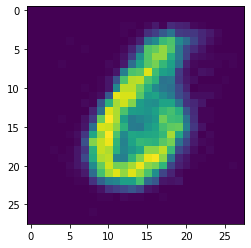

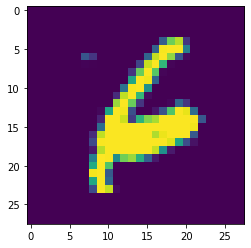

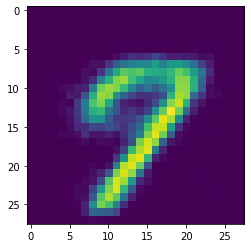

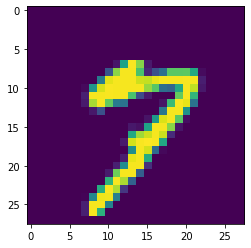

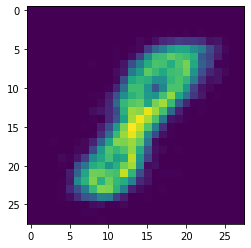

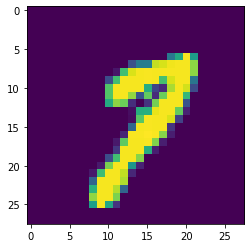

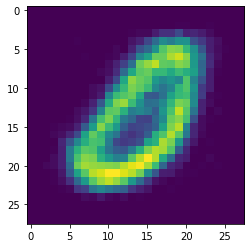

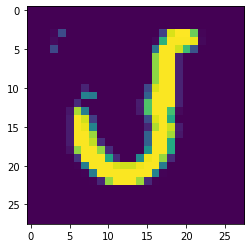

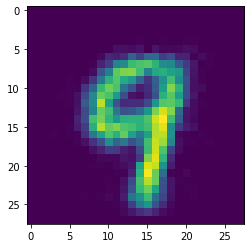

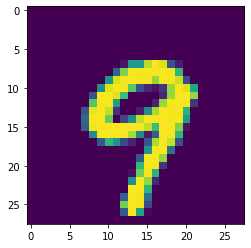

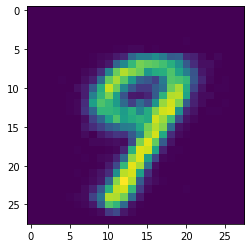

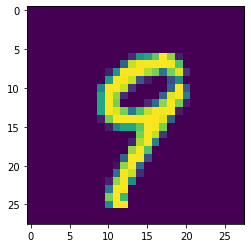

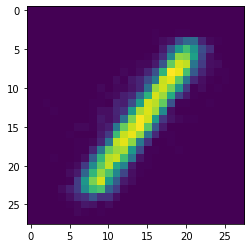

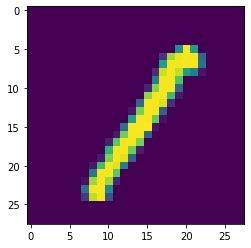

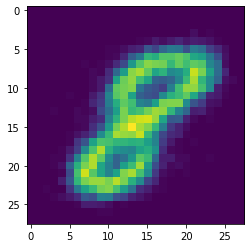

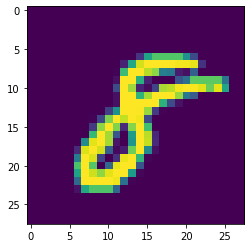

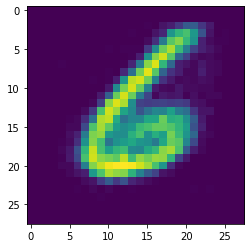

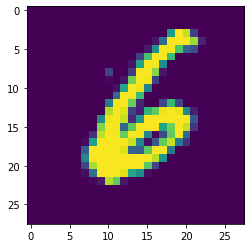

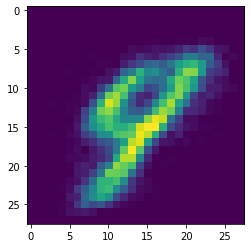

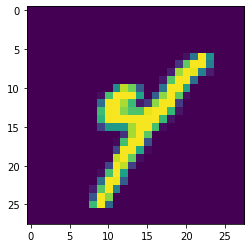

In [24]:
for data_pt_no in range(10):
    plt.imshow(np.mean(p_x[data_pt_no].sample(100),0).reshape((28,28))); plt.show()
    plt.imshow(np_x1[data_pt_no].numpy().reshape((28,28))); plt.show()

## Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

In [25]:
batch, N, K = samples.shape

In [26]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [27]:
logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
p_x = tfp.distributions.Bernoulli(logits=logits_x)
np_x = p_x.mean().numpy()

In [28]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [29]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5, 1.0, 'Generated Images')

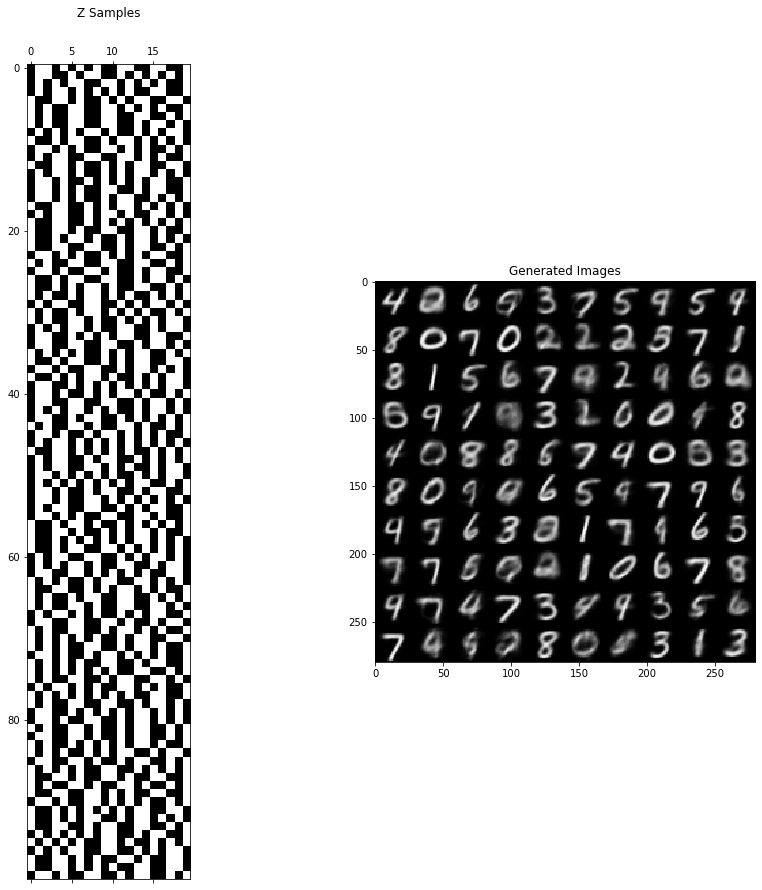

In [30]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

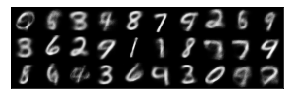

In [31]:
np.random.seed(123)
ys = []
for _ in range(3):
    xs = []
    for _ in range(10):
        np_y = np.zeros((N,K))
        np_y[range(N),np.random.choice(K,N)] = 1
        np_y = np.reshape(np_y,[1,N,K])

        logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
        p_x = tfp.distributions.Bernoulli(logits=logits_x)
        np_x = p_x.mean().numpy()[0].reshape((28,28))
        xs.append(np_x)
    ys.append(np.hstack(xs))
img = np.vstack(ys)   

fig = plt.figure(figsize=(6.4, 1.5), dpi=72)
plt.imshow(img, cmap=plt.cm.gray,interpolation='none')
plt.xticks([],{})
plt.yticks([],{})
plt.savefig("vae_flows.pdf", bbox_inches = 'tight', pad_inches =0)